<class 'pandas.core.frame.DataFrame'>
Int64Index: 22470 entries, 0 to 22469
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   site_id       22470 non-null  object        
 1   meter_id      22470 non-null  object        
 2   timestamp     22470 non-null  datetime64[ns]
 3   sensor_name   22470 non-null  object        
 4   sensor_value  22470 non-null  float64       
 5   status        22470 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.2+ MB
None
       sensor_value
count  22470.000000
mean      48.431380
std       25.278404
min       15.000000
25%       26.770000
50%       40.090000
75%       70.270000
max      100.000000
Outliers detected: Empty DataFrame
Columns: [site_id, meter_id, timestamp, sensor_name, sensor_value, status, z_score]
Index: []
  site_id  sensor_value
0  Site_A     225450.53
1  Site_B     220911.02


C:\Users\rudra\AppData\Local\Temp\ipykernel_2924\1312965556.py:23: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.median(), inplace=True)
C:\Users\rudra\AppData\Local\Temp\ipykernel_2924\1312965556.py:23: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.median(), inplace=True)


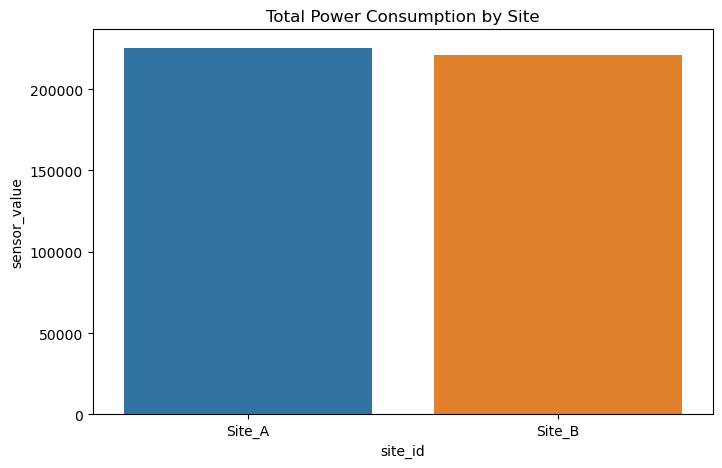

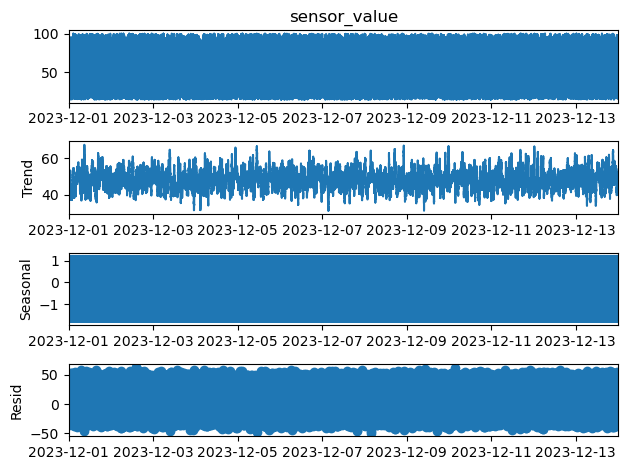

C:\Users\rudra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rudra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rudra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rudra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Forecast: 22470    35.578228
22471    40.150304
22472    43.492106
22473    45.190566
22474    36.958796
22475    37.125601
22476    39.860569
22477    40.591279
22478    40.497166
22479    39.933246
Name: predicted_mean, dtype: float64


C:\Users\rudra\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Detected anomalies:       site_id        meter_id           timestamp        sensor_name  \
3775   Site_A  Site_A_Meter_2 2023-12-01 02:30:00  power_consumption   
3777   Site_A  Site_A_Meter_2 2023-12-01 02:40:00           humidity   
7535   Site_A  Site_A_Meter_3 2023-12-01 03:45:00  power_consumption   
69     Site_A  Site_A_Meter_1 2023-12-01 05:45:00  power_consumption   
7585   Site_A  Site_A_Meter_3 2023-12-01 07:55:00           humidity   
...       ...             ...                 ...                ...   
11126  Site_A  Site_A_Meter_3 2023-12-13 15:00:00  power_consumption   
11161  Site_A  Site_A_Meter_3 2023-12-13 17:55:00  power_consumption   
18662  Site_B  Site_B_Meter_2 2023-12-13 18:50:00  power_consumption   
22427  Site_B  Site_B_Meter_3 2023-12-13 20:30:00           humidity   
11200  Site_A  Site_A_Meter_3 2023-12-13 21:10:00  power_consumption   

       sensor_value    status   z_score  anomaly  
3775          99.91    active  2.036512       -1  
3777         

C:\Users\rudra\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


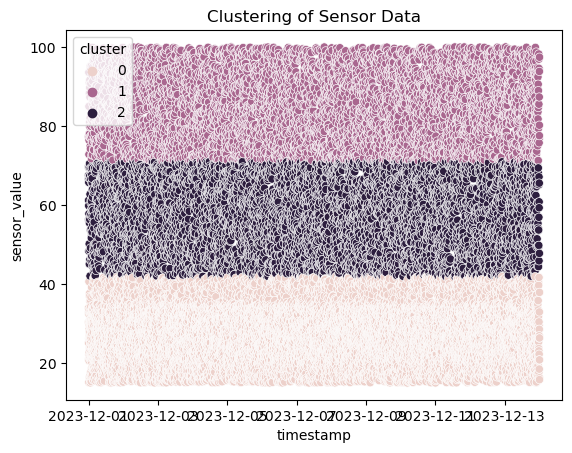

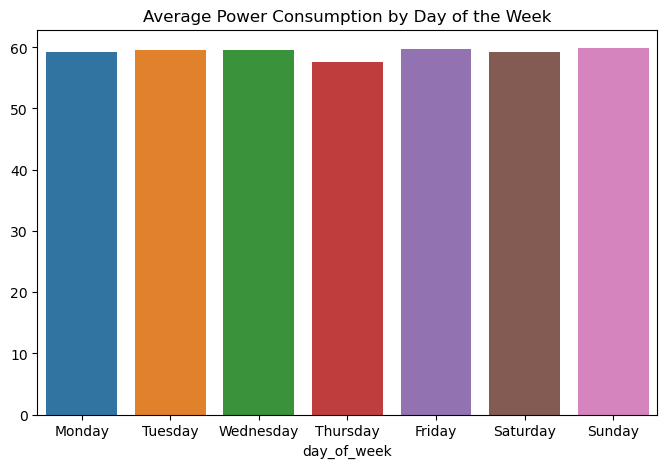

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from sklearn.cluster import KMeans

# Load the CSV file
data_path = "IoT_Sensor_Data (1).csv"
df = pd.read_csv(data_path)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Data Exploration
print(df.info())
print(df.describe())

# Handling Missing Data
df.fillna(df.median(), inplace=True)

# Outlier Detection using Z-score
df['z_score'] = stats.zscore(df['sensor_value'])
outliers = df[df['z_score'].abs() > 3]
print("Outliers detected:", outliers)

# Total power consumption by site
total_power_df = df[df['sensor_name'] == 'power_consumption'].groupby('site_id')['sensor_value'].sum().reset_index()
if total_power_df.empty:
    print("No data available for total power consumption analysis.")
else:
    total_power_df.to_csv("total_power_consumption.csv", index=False)
    print(total_power_df.head())
    plt.figure(figsize=(8, 5))
    sns.barplot(x='site_id', y='sensor_value', data=total_power_df)
    plt.title('Total Power Consumption by Site')
    plt.savefig('total_power_consumption.png')
    plt.show()

# Trend and Seasonality Analysis
decomposition = seasonal_decompose(df.set_index('timestamp')['sensor_value'], model='additive', period=24)
decomposition.plot()
plt.savefig('trend_seasonality.png')
plt.show()

# Forecasting with ARIMA
model = ARIMA(df['sensor_value'], order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=10)
print("Forecast:", forecast)

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
df['anomaly'] = iso_forest.fit_predict(df[['sensor_value']])
anomalies = df[df['anomaly'] == -1]
print("Detected anomalies:", anomalies)

# Clustering Analysis using K-Means
kmeans = KMeans(n_clusters=3)
df['cluster'] = kmeans.fit_predict(df[['sensor_value']])
sns.scatterplot(x='timestamp', y='sensor_value', hue='cluster', data=df)
plt.title('Clustering of Sensor Data')
plt.savefig('clustering.png')
plt.show()

# KPI Tracking
df['day_of_week'] = df['timestamp'].dt.day_name()
avg_by_day = df[df['sensor_name'] == 'power_consumption'].groupby('day_of_week')['sensor_value'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values)
plt.title('Average Power Consumption by Day of the Week')
plt.savefig('power_by_day.png')
plt.show()

# Interactive Visualization using Plotly
fig = px.line(df, x='timestamp', y='sensor_value', color='site_id', title='Power Consumption Over Time')
fig.show()
